## Измерить сечение

In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import os.path
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [91]:
SEASON = 20
N_MC = 20000

In [92]:
exp_tree = uproot.open(f'../trees/{SEASON}/exp.root')['t']
mc_tree = uproot.open(f'../trees/{SEASON}/mc.root')['t']
df_exp = preprocess.read_tree(exp_tree, mc=False)
df_mc = preprocess.read_tree(mc_tree, mc=True)

assert np.any( df_exp.groupby('ebeam').agg(emean = ('emeas', 'mean'), uniqs = ('emeas', 'nunique')).uniqs==1 ) #check energies in df
assert np.any( df_mc.groupby('ebeam').agg(emean = ('emeas', 'mean'), uniqs = ('emeas', 'nunique')).uniqs==1 )

In [94]:
# df_exp.ksalign.hist(bins=100);

____
## Fit part

In [95]:
energies_list = df_exp.index.unique() & df_mc.index.unique()
for i in sorted(energies_list):
    print(i, end=' ')
it = iter(energies_list)

935.0 945.0 950.0 960.0 970.0 

[$\chi^2$-calculator](https://www.di-mgt.com.au/chisquare-calculator.html)

In [96]:
fit_range = (-40, 20)
hist_range = (-40, 40)
width = fit_range[1] - fit_range[0]

params = {
    'n_sig': (1000, (0, None)),    
    'n_bkg': (  10, (0, None)),    
    'm'    : (   0, (-5, 5)),
    'sL'   : (   2, (1, 10)),
    'sR'   : (   5, (1, 10)),
    'aL'   : (   0, (0, 10)),
    'aR'   : (   0, (0, 10)),
    'k'    : ( 0.1, (0, 20)),
}

In [97]:
def get_x1(df_exp, df_mc, e0):
    dfE = df_exp.loc[e0].copy()
    dfM =  df_mc.loc[e0].copy()
    assert dfM.runnum.nunique()==1
    return dfE, dfM
    
def get_params_exp(params, m_mc, non_limited=['n_sig', 'n_bkg', 'k']):
    params_exp = params.copy()
    for k in m_mc.parameters:
        params_exp[k] = ( m_mc.values[k], params_exp[k][1] )
        if k not in non_limited:
            mean, std = m_mc.values[k], 3*m_mc.errors[k]
            params_exp[k] = ( m_mc.values[k],(mean-std, mean+std) )
    return params_exp

In [127]:
e0 = next(it)
print(f'Energy {e0} MeV')

StopIteration: 

In [121]:
dfE, dfM = get_x1(df_exp, df_mc, e0)
dataE, dataM = dfE.x1.values, dfM.x1.values

m_mc = pyfit.fitter(dataM, fit_range, params.copy(), mc=True)
m_mc.simplex().migrad(iterate=20)
assert m_mc.valid

params_exp = get_params_exp(params, m_mc, ['n_sig', 'n_bkg', 'k'])
m_exp = pyfit.fitter(dataE, fit_range, params_exp, mc=False)
m_exp.simplex().migrad(iterate=20).migrad().migrad()
assert m_exp.valid

In [125]:
m_exp.minos()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -478.5                     │             Nfcn = 7636              │
│ EDM = 4.67e-08 (Goal: 0.1)       │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_sig │    102    │    11     │    -22     │     15     │    0    │         │       │
│ 1 │ n_bkg │    192    │    13     │    -16     │     25     │    0    │         │       │
│ 2 │ m     │1.024389256606│1.510841438578│-0.282617067497│0.000000000015│-0.493414│ 1.02439 │       │
│ 3 │ sL    │2.095425627│0.704177804│-0.000000007│0.237885200 │ 2.09543 │ 3.15666 │       │
│ 4 │ sR    │2.0917102905│0.1920057779│-0.0000000007│0.1920057779│ 2.09171 │ 3.55102 │       │
│ 5 │ aL    │88.257926562e-3│20.825044161e-3│-0.000000027e-3│24.270256993e-3│0.0882579│0.112528 │       │
│ 6 │ aR    │158.47728e-3│27.66093e-3│-54.94772e-3│ 0.00004e-3 │ 0.10353 │0.158477 │       │
│ 7 │ k     │   0.034   │   0.012   │   -0.010   │   0.028    │    0    │   20    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │         n_sig         │         n_bkg         │           m           │          sL           │          sR           │          aL           │          aR           │           k           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │    -22    │    15     │    -16    │    25     │-282617067.497e-9│ 0.015e-9  │   -7e-9   │237885200e-9│  -0.7e-9  │192005777.9e-9│ -0.027e-9 │24270256.993e-9│-54947.72e-6│  0.04e-6  │  -0.010   │   0.028   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   False   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   True    │   True    │   False   │   True    │   False   │   True    │   True    │   True    │   True    │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────┬─────────────────────────────────────────────────────────────────────────────────┐
│       │     n_sig     n_bkg         m        sL        sR        aL        aR         k │
├───────┼──────────────────────────────────────────────────────

,n_sig_exp,n_bkg_exp,n_sig_mc
935.0,91.352114,179.647935,447.935525
945.0,79.874775,85.125234,550.939988
950.0,133.352210,138.647813,555.011822
960.0,133.058235,212.943228,709.878170
970.0,101.949186,192.050907,766.994274


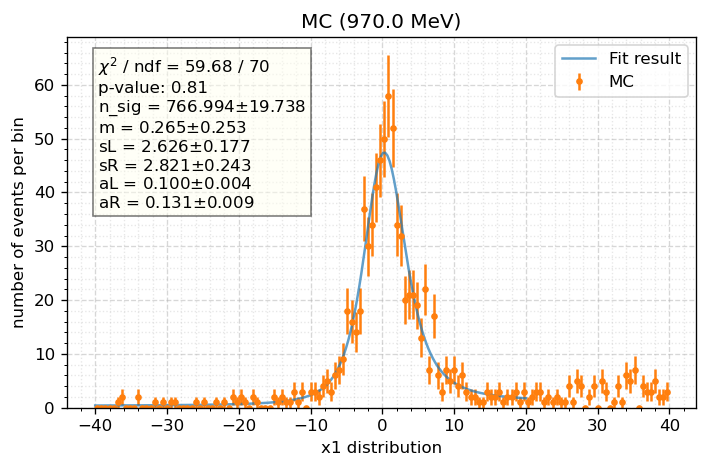

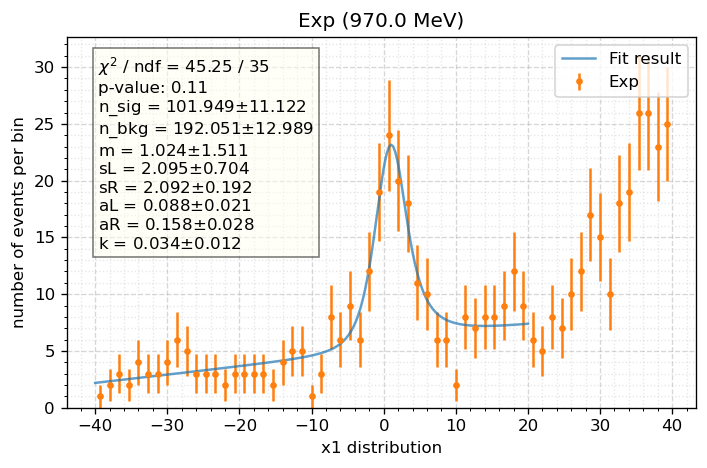

In [126]:
#Plot and save data

def plot_fit_data(save=True):
    pys.plot_fit(dataM, pyfit.sig_pdf, m_mc, 140, hist_range, fit_range, errors=True, label='MC', xtitle='x1 distribution',
               ytitle='number of events per bin', title=f'MC ({e0} MeV)', description=True)
    if save:
        if not(os.path.isdir(f'images/fit{SEASON}')):
            os.mkdir(f'images/fit{SEASON}')
        plt.savefig(f'images/fit{SEASON}/mc_{e0}.png', dpi=120)

    pys.plot_fit(dataE, pyfit.pdf, m_exp, 60, hist_range, fit_range, errors=True, label='Exp', xtitle='x1 distribution',
               ytitle='number of events per bin', title=f'Exp ({e0} MeV)', description=True)
    if save:
        plt.savefig(f'images/fit{SEASON}/exp_{e0}.png', dpi=120)

plot_fit_data(save=True)
    
if 'res_df' not in locals():
    def add_postfix(arr, post):
        return [f'{_}_{post}' for _ in arr]
    cols = add_postfix(m_exp.parameters, 'exp') + add_postfix(m_exp.parameters, 'exp_err') + \
        add_postfix(m_mc.parameters, 'mc') + add_postfix(m_mc.parameters, 'mc_err') + ['emeas']
    res_df = pd.DataFrame(columns=cols)
    del cols
temp_ser = pd.Series(list(m_exp.values) + list(m_exp.errors) + 
                     list(m_mc.values) + list(m_mc.errors) + [dfE.emeas.mean()], index=res_df.columns, name=e0)
if temp_ser.name in res_df.index:
    res_df.drop(temp_ser.name, axis=0, inplace=True)
res_df = res_df.append(temp_ser)
del temp_ser

res_df[['n_sig_exp', 'n_bkg_exp', 'n_sig_mc']].tail()

Распределения

In [128]:
# res_df.to_csv(f'../data/{SEASON}/results/signal.csv')

In [86]:
res_df[['n_sig_exp', 'n_sig_exp_err']]

,n_sig_exp,n_sig_exp_err
640.0,110.179383,8.328471
680.0,93.836731,9.162935
720.0,58.979413,9.396211
760.0,96.764192,8.654418
800.0,173.270563,9.848327
840.0,155.232013,11.464266
860.0,56.829872,7.099921
880.0,25.536358,4.617519
900.0,11.054915,3.085570
920.0,14.535410,3.593366


Triggers

In [129]:
df_exp

,runnum,emeas,trigbits,tth[0],tth[1],tz[0],tz[1],tptot[0],tptot[1],trho[0],...,ksminv,ksptot,ksalign,kslen,ksdpsi,kspipt[0],kspipt[1],x1,x2,ksangle
ebeam,,,,,,,,,,,,,,,,,,,,,
935.0,89976,934.711914,1,1.195417,1.839436,-12.594906,-11.709505,215.796448,166.013687,-1.413034,...,476.954498,43.265106,0.964465,10.660483,3.034197,213.240005,175.276932,215.860516,-716.460541,0.267384
935.0,89977,934.711914,1,1.404132,1.105659,7.142300,6.016761,465.330902,113.321960,0.328771,...,538.081116,404.763336,0.923170,1.262139,2.342377,474.561127,111.539185,160.084797,-354.098149,0.394550
935.0,89977,934.711914,1,1.342268,1.615378,9.568758,8.346758,251.399765,247.995834,-3.916666,...,574.207153,43.891533,0.985353,22.526104,2.969833,255.730377,247.962784,307.971895,-685.252124,0.171366
935.0,89979,934.711914,1,2.164800,1.109074,-8.636611,-8.627090,201.624100,293.955048,-4.863655,...,553.080261,104.115295,0.981841,7.006157,2.910901,199.159790,287.512085,268.961407,-634.740453,0.190864
935.0,89979,934.711914,3,0.956319,2.026080,-4.990336,-5.755877,200.632996,182.720856,-1.423167,...,471.945679,35.272327,0.979574,100.841072,2.978604,199.371918,182.675751,213.622353,-725.623696,0.202463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970.0,96626,970.583313,3,1.935431,1.656314,-0.555425,-0.901419,568.603882,191.686661,0.241960,...,497.307037,654.380249,0.999749,0.821691,1.250007,568.768188,190.630875,54.230108,-170.527021,0.022408
970.0,96626,970.583313,3,1.790303,0.596598,-2.754993,-2.313279,325.648621,186.922699,-0.900730,...,512.415649,293.835144,0.997448,2.492644,2.039225,325.631592,190.805069,178.449515,-509.334609,0.071460
970.0,96627,970.583313,3,1.915156,1.165038,-0.834168,-1.887698,459.055206,156.014404,0.294847,...,498.152008,470.625092,0.999070,1.137610,1.641051,455.127991,155.913300,111.010209,-345.291697,0.043133


In [130]:
trig_df = pd.DataFrame()
for ee in energies_list:
    dfE = df_exp.loc[ee].copy()
    dfM = df_mc.loc[ee].copy()
#     print(ee)
    assert dfM.runnum.nunique()==1
    xmin, xmax = fit_range
    dfE = dfE.query('x1<@xmax&x1>@xmin')[['trigbits']]
    dfE[ee] = 1
    trig_df = trig_df.append(pd.pivot_table(dfE, values=ee, columns='trigbits', aggfunc='sum'))
trig_df = trig_df.fillna(0).drop(0, axis=1).rename({1: 'TF', 2: 'CF', 3:'TC'}, axis=1)

In [131]:
t, c, tc = trig_df['TF'] + trig_df['TC'], trig_df['CF'] + trig_df['TC'], trig_df['TC']

trig_df['effT'] = (tc + 1)/(c + 2)
trig_df['effC'] = (tc + 1)/(t + 2)

trig_df['effT_err'] = np.sqrt( (tc+1)*(tc+2)/(c+2)/(c+3) - ((tc+1)/(c+2))**2 )
trig_df['effC_err'] = np.sqrt( (tc+1)*(tc+2)/(t+2)/(t+3) - ((tc+1)/(t+2))**2 )

trig_df['eff_trig']  = 1 - (1-trig_df.effT)*(1-trig_df.effC)
trig_df['eff_trig_err']  = np.sqrt( (trig_df.effT_err*(1-trig_df.effC))**2 
                             + (trig_df.effC_err*(1-trig_df.effT))**2 )

In [132]:
# trig_df.to_csv(f'../data/{SEASON}/results/triggers.csv')

Если не фиксировать параметры в экспериментальном распределении, то провожу статистический тест.

Гипотеза $H_0$ - параметры распределений в эксперименте и моделировании одинаковы

Проверяем гипотезу на уровне значимости 5% = $2 \cdot \sigma$

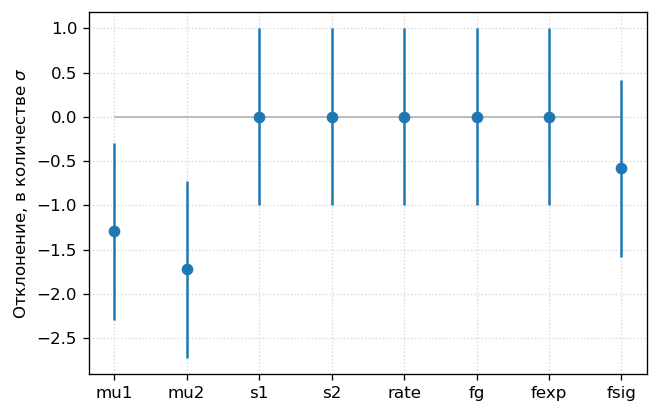

In [639]:
valsE, errsE = m_exp.values, m_exp.errors
valsM, errsM = m_mc.values, m_mc.errors
x0, ex = [], []
var =  ['mu1', 'mu2', 's1', 's2', 'rate', 'fg', 'fexp', 'fsig']
for k in var:
    error = (np.sqrt(errsE[k]**2 + errsM[k]**2))
    x0.append((valsE[k] - valsM[k])/error)
    
plt.hlines(y=0, xmin=0, xmax=len(x0)-1, zorder=-1, color='k', lw=1, alpha=0.3)
plt.errorbar(range(len(x0)), x0, yerr=1, fmt='o')
plt.grid(ls=':', alpha=0.5)
plt.ylabel('Отклонение, в количестве $\\sigma$')
plt.xticks(range(len(x0)), var);
# del valsE, valsM, errsE, errsM